In [45]:
import numpy as np
import pandas as pd
#pd.set_option('max_columns', 5000)
import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_style('darkgrid')
from scipy.stats import norm, skew, probplot
from scipy.special import boxcox1p
import warnings
warnings.filterwarnings(action='ignore')

from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge as krr
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor as rfr, GradientBoostingRegressor as gbr
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.cluster import DBSCAN

import optuna
from functools import partial

In [46]:
# Get the data into dataframes
df_train = pd.read_csv("../lab2/train.csv")
df_test  = pd.read_csv("../lab2/test.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Skewness of SalePrice:  1.8828757597682129
Kurtosis of SalePrice:  6.536281860064529


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

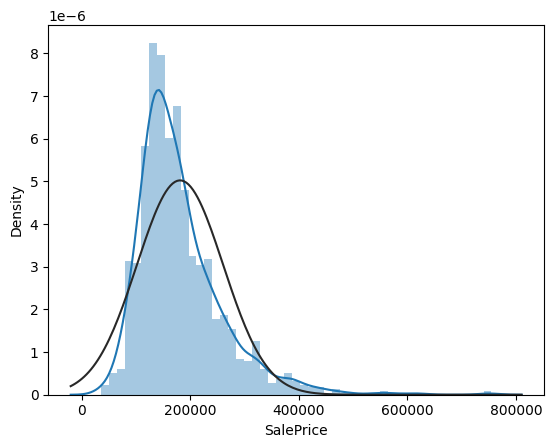

In [47]:
# Step One: EDA (Exploratory Data Analysis)

# First, lets try to understand the dependent variable: SalePrice
# We want to know if the variable is normal
# We can do this by drawing a histogram
print("Skewness of SalePrice: ", df_train["SalePrice"].skew())
print("Kurtosis of SalePrice: ", df_train["SalePrice"].kurt())
sns.distplot(df_train["SalePrice"], fit = norm)

In [48]:
# From our visualizations we see that the dependent variable is not normalized
# To solve this, we can use a log transformation or boxcox transformation.
# All skewed features will require this in the processing phase

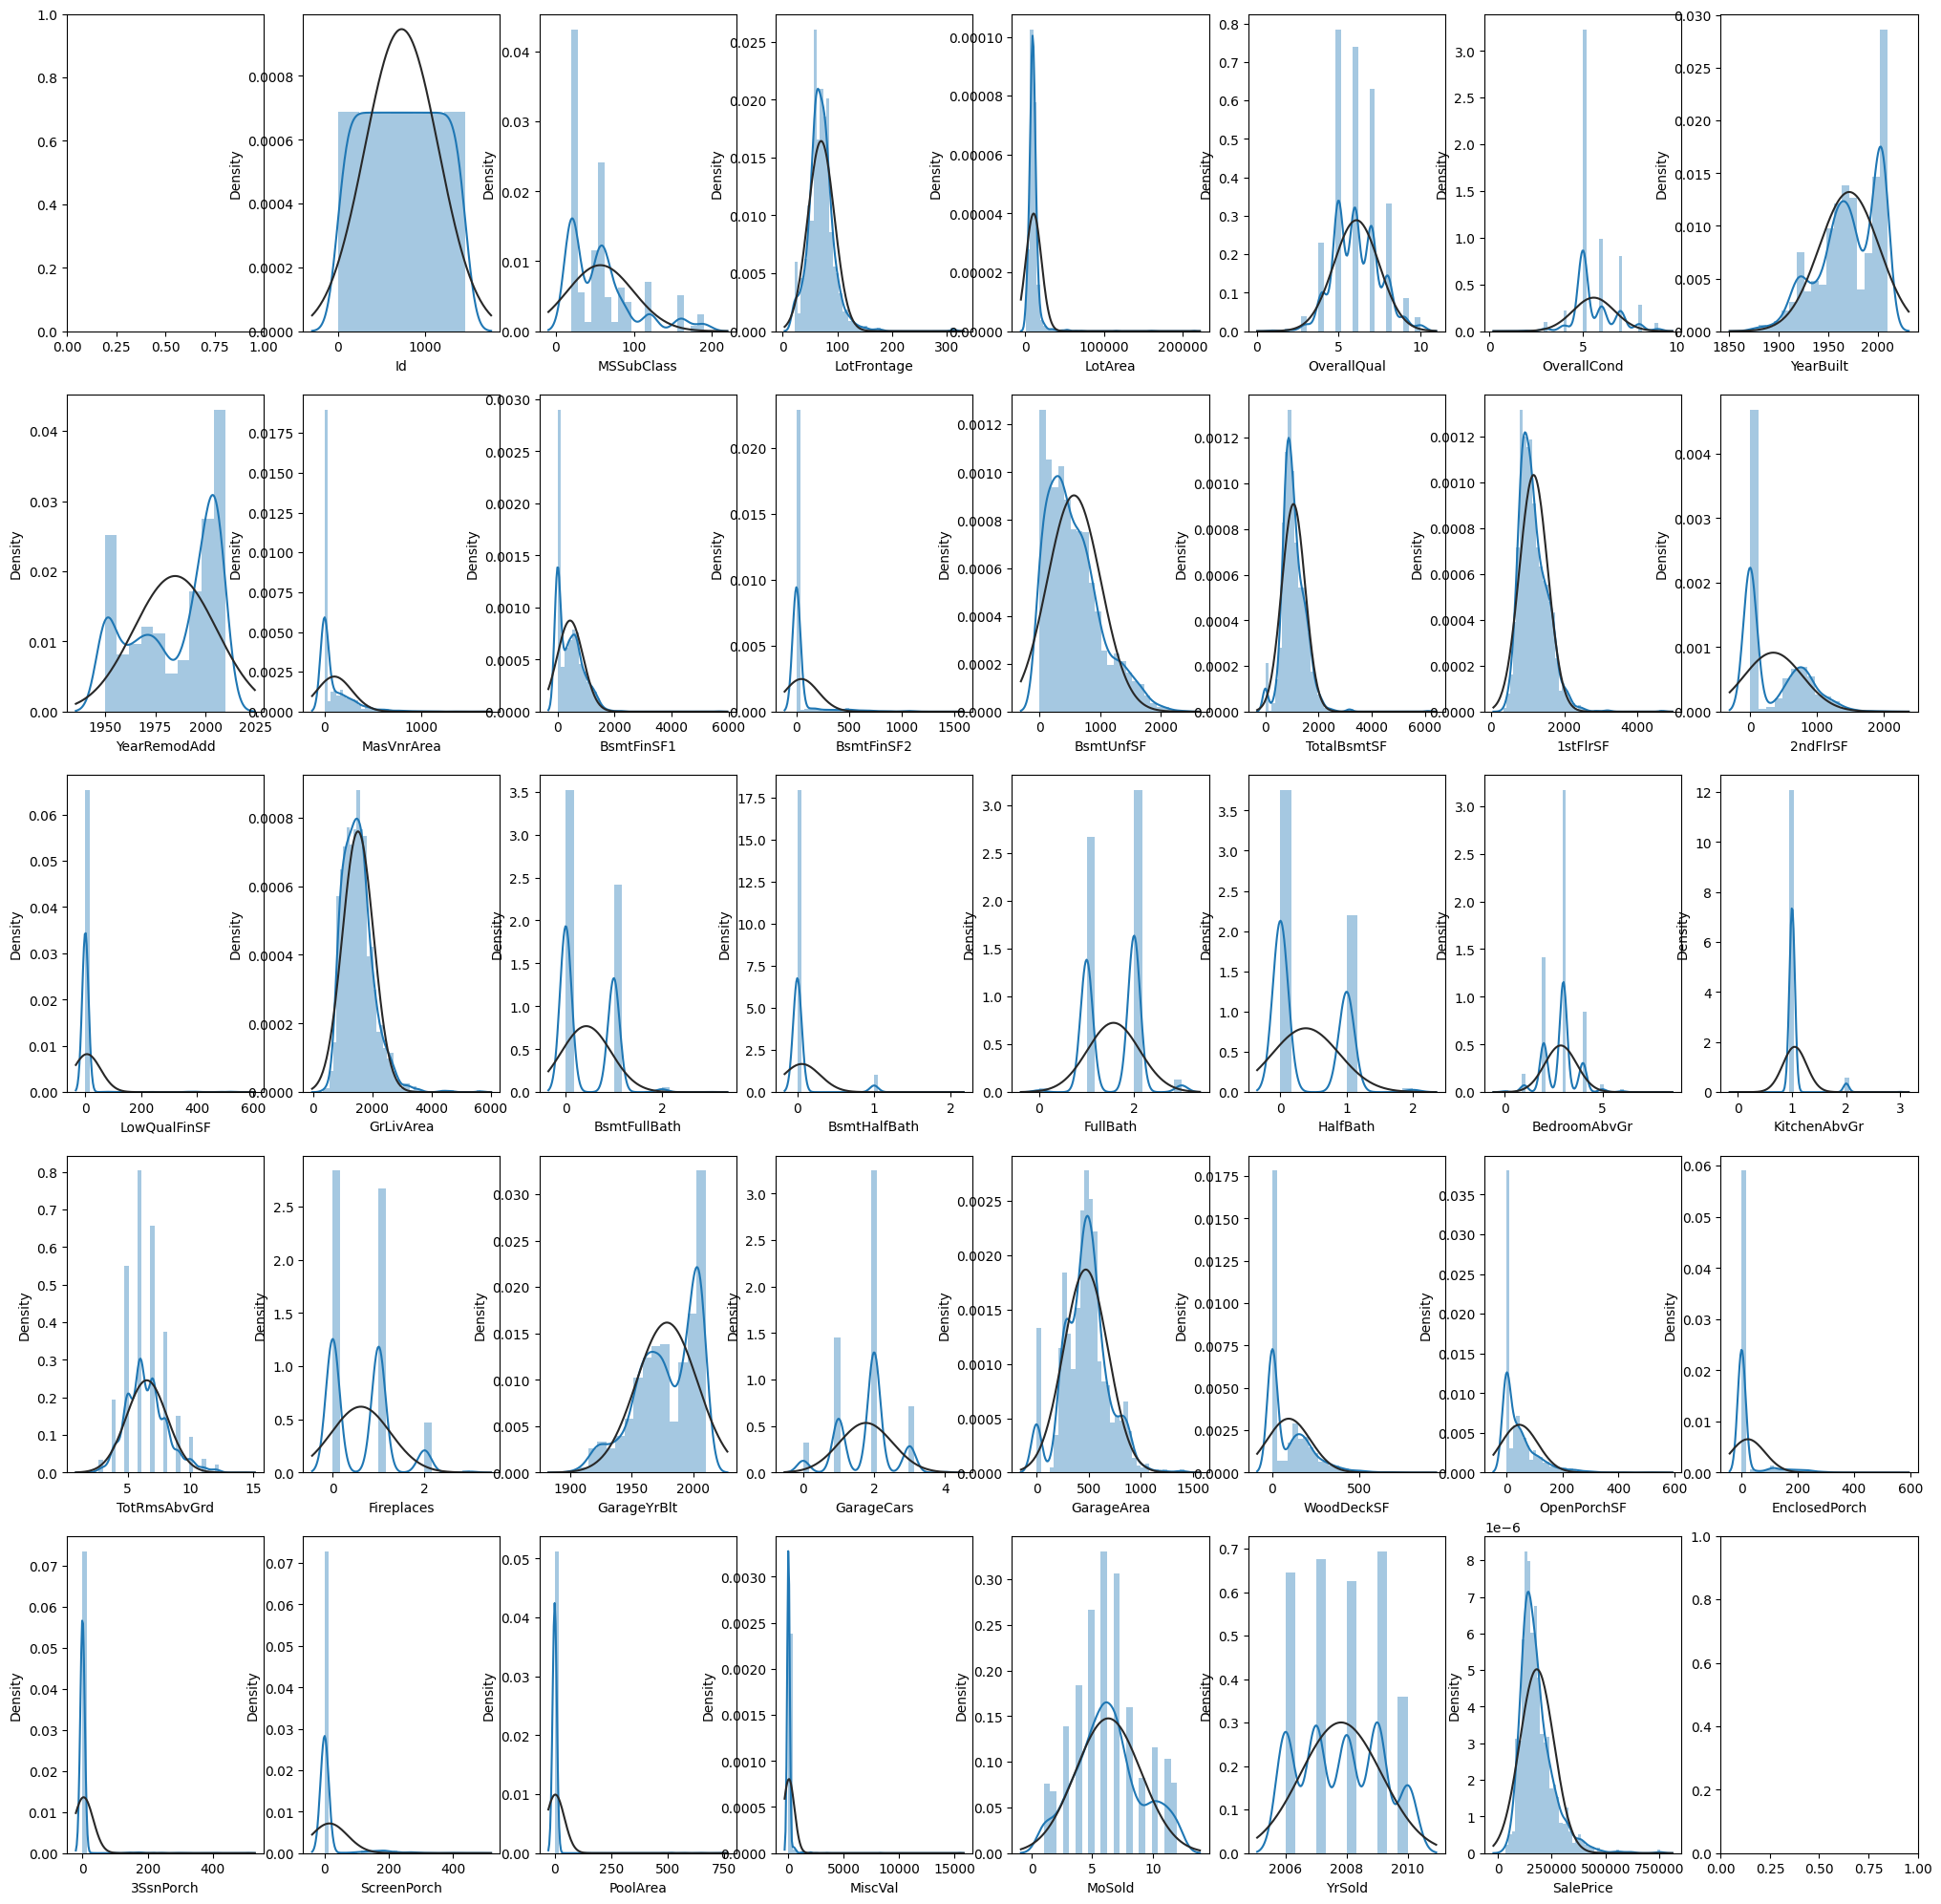

In [49]:
# Here we see that many are skewed
fig, axs = plt.subplots(5, 8, figsize = (25,25))
i = 0
j = 0
for feature in df_train.columns[df_train.dtypes != 'object']:
    if j == 7:
        i += 1
        j = 0
    else:
        j += 1
    sns.distplot(df_train[feature], fit = norm, ax = axs[i,j])
plt.show()

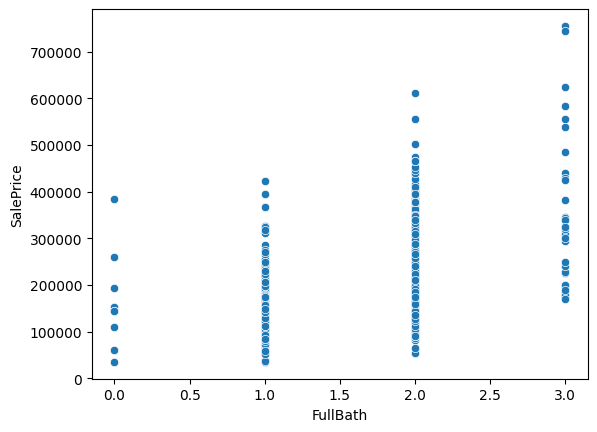

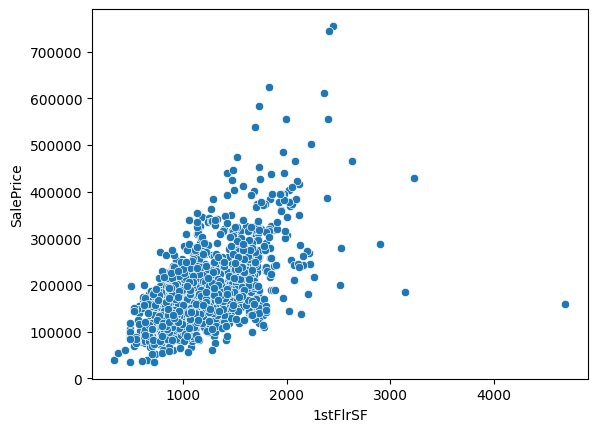

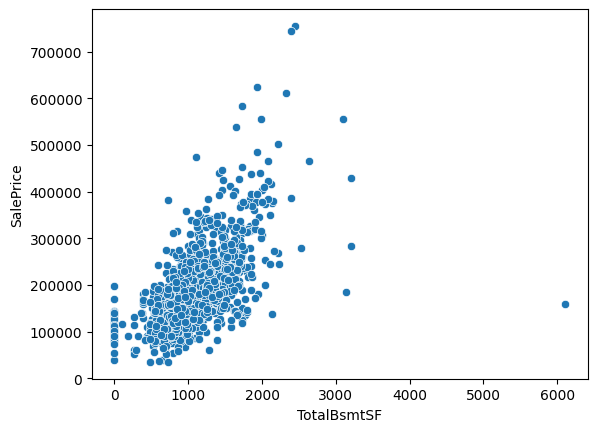

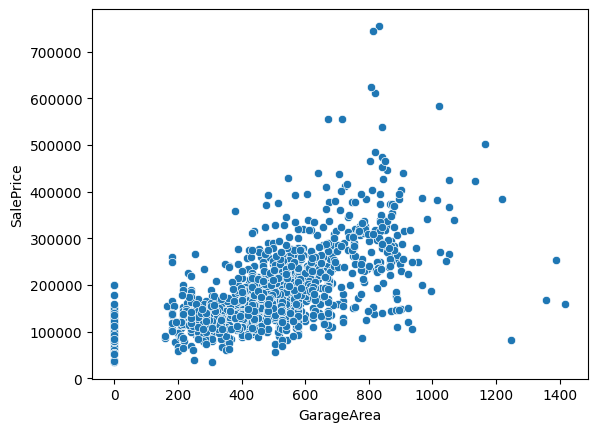

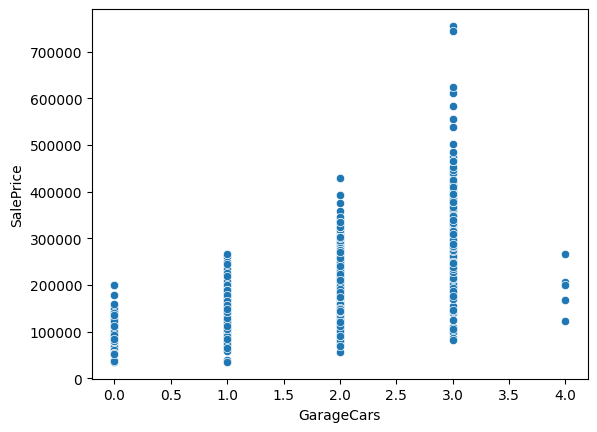

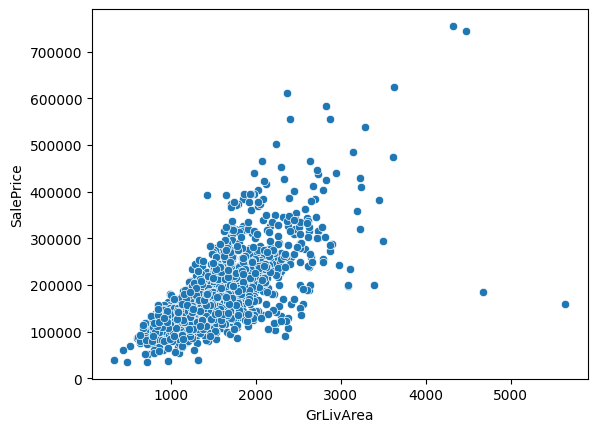

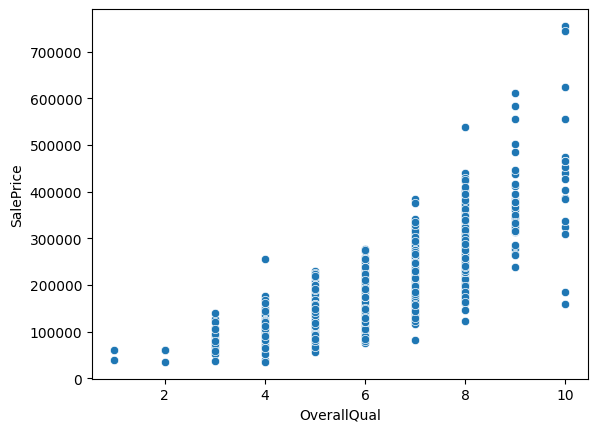

In [50]:
# Lets clean our data
# First lets count for significant outliers
# Find the most correlated features
corrmat = abs(df_train.corr()["SalePrice"])
corrmat = corrmat.sort_values()
imp_feats = corrmat[len(corrmat) - 8: len(corrmat) - 1].index
for feature in imp_feats:
    sns.scatterplot(x = df_train[feature], y = df_train["SalePrice"])
    plt.ylabel("SalePrice")
    plt.xlabel(feature)
    plt.show()

We see that the following properties have outliers: GrLivArea, TotalBsmtSF, 1stFlrSF
All of these outliers are the same, where big SF is not correlating with price.
We should change this.

In [51]:
# remove the houses from GrLivArea with SF above 4000
# remove the house with TotalBsmtSF above 5000
# remove the house with 1stFlrSF above 4000
print("Size before removing outliers: ", df_train.shape)
remove = set()
for index, value in enumerate(df_train["GrLivArea"]):
    if value > 4000:
        remove.add(index)
for index, value in enumerate(df_train["TotalBsmtSF"]):
    if value > 4000:
        remove.add(index)
for index, value in enumerate(df_train["1stFlrSF"]):
    if value > 4000:
        remove.add(index)
df_train = df_train.drop(labels= [house for house in remove], axis = 0) # Axis zero indicates row
print("Size after removing outliers: ", df_train.shape)

Size before removing outliers:  (1460, 81)
Size after removing outliers:  (1456, 81)


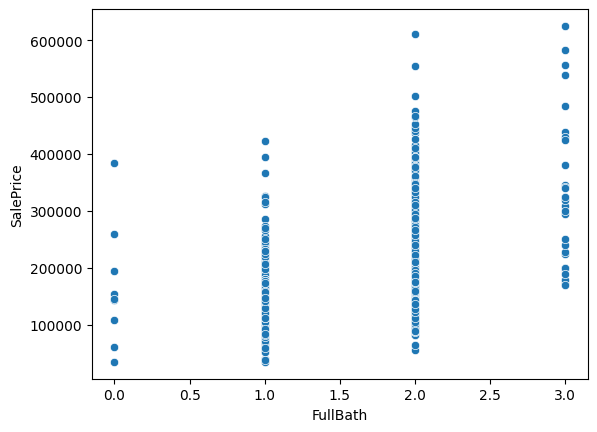

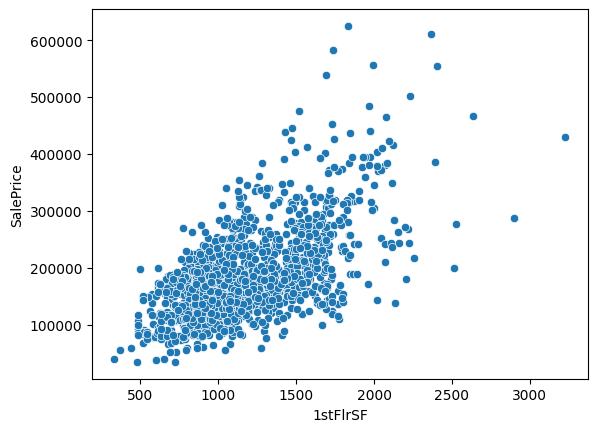

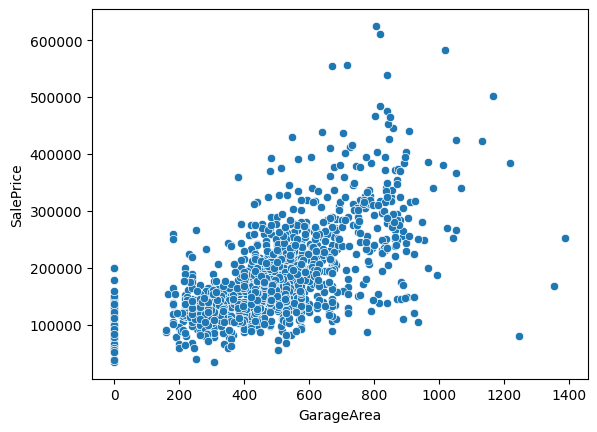

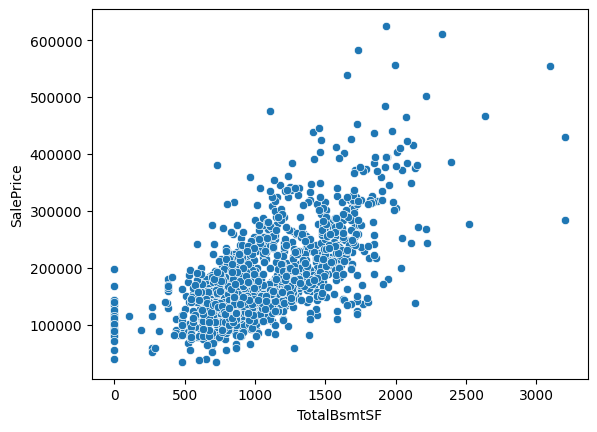

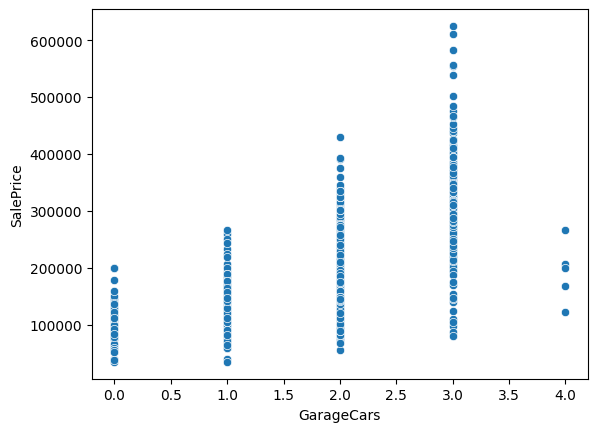

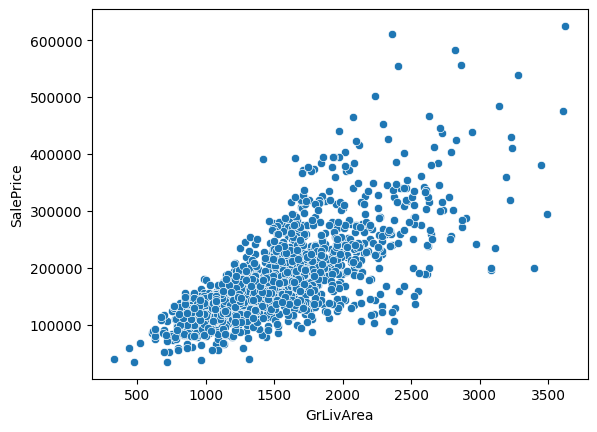

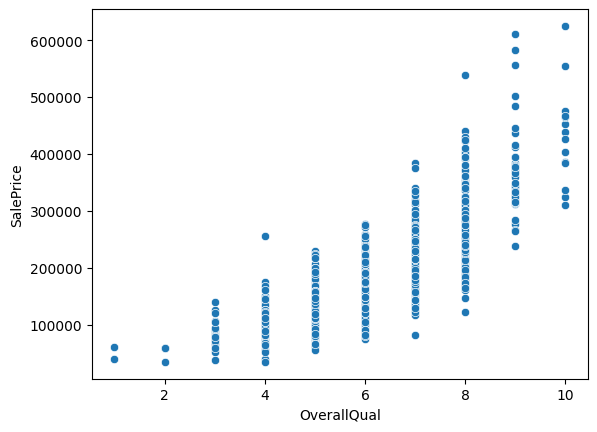

In [52]:
# Lets see if we removed those ouliers
corrmat = abs(df_train.corr()["SalePrice"])
corrmat = corrmat.sort_values()
imp_feats = corrmat[len(corrmat) - 8: len(corrmat) - 1].index
for feature in imp_feats:
    sns.scatterplot(x = df_train[feature], y = df_train["SalePrice"])
    plt.ylabel("SalePrice")
    plt.xlabel(feature)
    plt.show()

Some of our most important features are now going to be more accurate, and we only removed four houses

In [53]:
# Next less cleanse the data of Nan Values or empty cells
train_size = df_train.shape[0]
y_train = df_train.SalePrice.values
all_data = pd.concat((df_train, df_test), axis=0).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
train_id = df_train.Id
test_id = df_test.Id
all_data = all_data.drop("Id", axis = 1)

In [54]:
for c in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond','BsmtQual',
          'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',"PoolQC",
          'Alley','Fence','MiscFeature','FireplaceQu','MasVnrType','Utilities']:
    all_data[c] = all_data[c].fillna('None')
    
for c in ['GarageYrBlt', 'GarageArea', 'GarageCars','MasVnrArea','BsmtFinSF1',
          'BsmtFinSF2','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath',
          'BsmtUnfSF','TotalBsmtSF']:
    all_data[c] = all_data[c].fillna(0)

for c in ['Exterior1st','Exterior2nd','SaleType','Electrical','KitchenQual']:
    all_data[c] = all_data[c].fillna(all_data[c].mode()[0])

all_data['MSZoning'] = all_data.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))
all_data['Functional'] = all_data['Functional'].fillna('Typ')

First we replace categorical variables, with missing data, that correpond to something not being there with None. This is because, if a house doesnt have a garage, then None would be the appropriate value instead of Nan

Second, we replace numerical values corresponding with similarly missing categorical values with 0.

Third, numerical values that just have missing data and dont have easy explanations like the others we replace with teh average.

The last3 are feature specific. Replace the missing lot frontage value with the median of the neiborhood its in, for example.

In [55]:
all_data.isnull().sum().sum()

0

In [56]:
# We are now ready to normalize skewed numerical data
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index # .index means the names
for feat in numeric_feats:
    if all_data[feat].skew() > .5:
        all_data[feat] = boxcox1p(all_data[feat], boxcox_normmax(all_data[feat] + 1))
# Also unskew the prices
y_train = np.log1p(y_train)

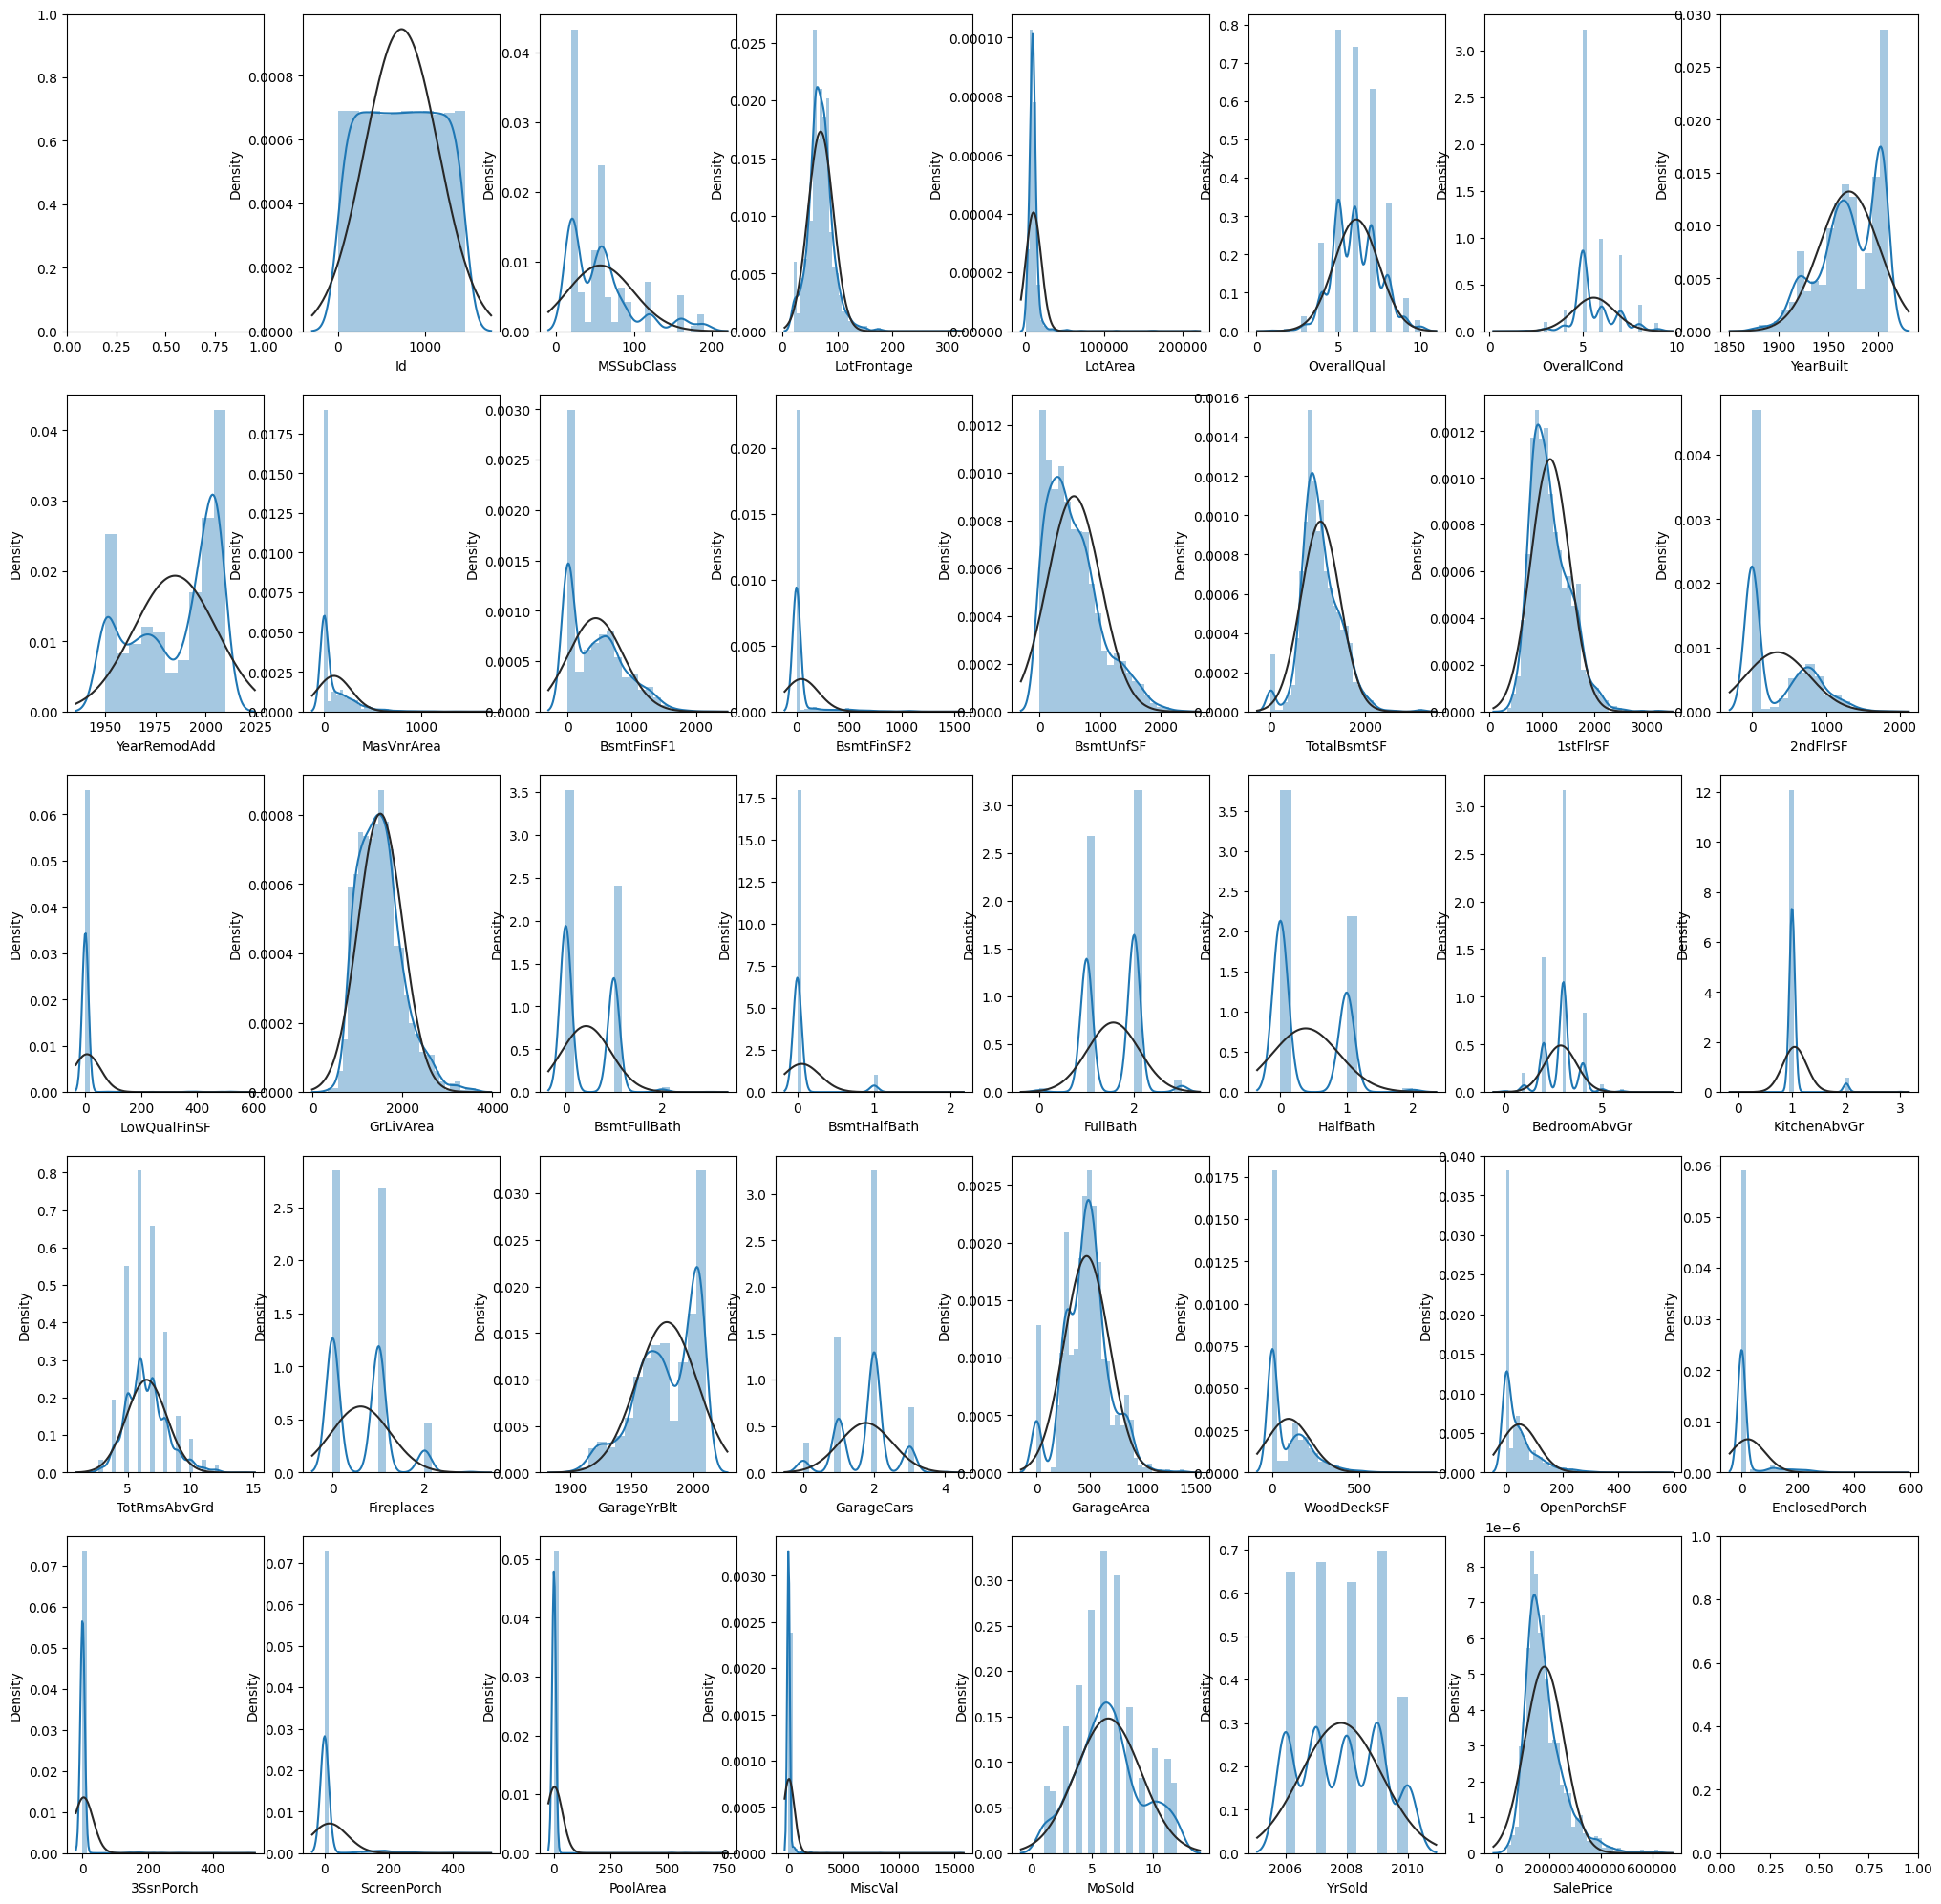

In [57]:
# Lets see how the data looks again
fig, axs = plt.subplots(5, 8, figsize = (25,25))
i = 0
j = 0
for feature in df_train.columns[df_train.dtypes != 'object']:
    if j == 7:
        i += 1
        j = 0
    else:
        j += 1
    sns.distplot(df_train[feature], fit = norm, ax = axs[i,j])
plt.show()

In [58]:
# Replace categorical data
all_data  = pd.get_dummies(all_data)
X_train = all_data[:df_train.shape[0]]
X_test = all_data[df_train.shape[0]:]

Text(0.5, 1.0, 'SalePrice Distribution')

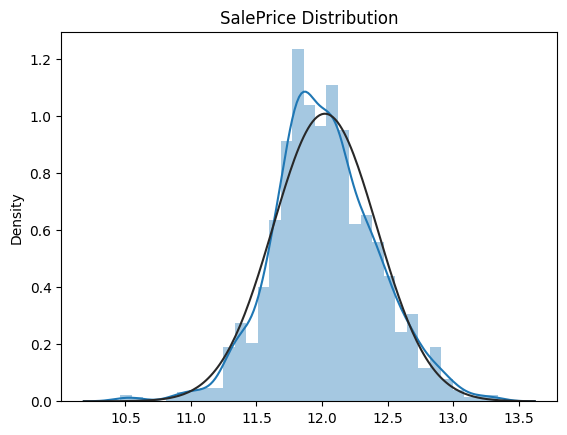

In [59]:
sns.distplot(y_train, fit = norm)
plt.title("SalePrice Distribution")

We can see that y has been normalized

In [63]:
# We are now ready for optimization and modeling

# We will try the same techniques, but use optimization to find the rightn hyperparameters

In [64]:
X_train.shape, X_test.shape, y_train.shape

((1456, 302), (1459, 302), (1456,))

In [66]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators = 360, max_depth = 2, learning_rate = .1).fit(X_train, y_train)
xgb_preds = np.expm1(xgb_model.predict(X_test))
xgb_df = pd.DataFrame({"Id" : df_test["Id"],  "SalePrice" : xgb_preds})
xgb_df.to_csv("xgb1_feature_engineering.csv", index = False)
xgb_df.head()

,Id,SalePrice
0,1461,124936.156250
1,1462,157213.046875
2,1463,186735.359375
3,1464,192435.125000
4,1465,190921.187500


In [79]:
model_lasso = Pipeline([
    ('scaler', RobustScaler()),
    ('model', Lasso(alpha=0.0002))
])
grid_param_lasso = {
    'model__alpha': 0.0001 * np.arange(1, 100)
}
search_lasso = GridSearchCV(model_lasso, grid_param_lasso, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
lasso_preds = np.expm1(search_lasso.predict(X_test))
lasso_df = pd.DataFrame({"Id" : df_test["Id"], "SalePrice" : lasso_preds})
lasso_df.to_csv("LassoSimple_feature.csv", index = False)
lasso_df.head()

,Id,SalePrice
0,1461,120122.695696
1,1462,155580.651979
2,1463,183376.368076
3,1464,201256.260900
4,1465,194618.006008


In [81]:
model_krr = Pipeline([
    ('scaler', RobustScaler()),
    ('model', krr())
])
grid_param_krr = {
    'model__alpha': 0.0001 * np.arange(1, 100),
    'model__degree': [1, 2, 3],
    'model__kernel': ['polynomial'],
    'model__coef0': [2.5]
}
search_krr = GridSearchCV(model_krr, grid_param_krr, scoring='neg_mean_squared_error',
                           cv=5, n_jobs=-1, verbose=0).fit(X_train, y_train)
krr_preds = np.expm1(search_krr.predict(X_test))
krr_df = pd.DataFrame({"Id" : df_test["Id"], "SalePrice" : krr_preds})
krr_df.to_csv("Krr_feature.csv", index = False)
krr_df.head()

,Id,SalePrice
0,1461,119560.235154
1,1462,153629.365868
2,1463,187048.665925
3,1464,200132.207705
4,1465,195889.273382


We still have optimizing to do, and to master stacking; but we are hopeful that the feature engineering  + optimizing parameters  + stacking will yield the best results

In [91]:
import math
def train_rmse(model):
    preds = model.predict(X_train)
    y_arr = y_train
    res = [0 for i in range(len(y_arr))]
    for i in range(len(y_arr)):
        res[i] = (y_arr[i] - preds[i]) ** 2
    return math.sqrt(sum(res))

In [92]:
#Lets generate an under-fitting model

xgb_model = xgb.XGBRegressor(n_estimators = 100, max_depth = 1, learning_rate = .01, reg_alpha = 150, reg_lambda = 150, sub_sample = 0).fit(X_train, y_train)
xgb_preds = np.expm1(xgb_model.predict(X_test))
xgb_df = pd.DataFrame({"Id" : df_test["Id"],  "SalePrice" : xgb_preds})
xgb_df.to_csv("xgb1_underfit.csv", index = False)
train_rmse(xgb_model)

[20:36:19] WARNING: ../src/learner.cc:627: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




179.8251927812042

Kaggle Score of 4.7905 and a  predicted score 179.8251927812042. Poorly on both means underfitting; we achieved this by reducing the complexity of the model by making the regularization parameters very large, and the depth of the decision trees small.

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 100000, max_depth = 10000, learning_rate = .01, reg_alpha = 0,reg_lambda = 0, sub_sample = 1).fit(X_train, y_train)
xgb_preds = np.expm1(xgb_model.predict(X_test))
xgb_df = pd.DataFrame({"Id" : test["Id"],  "SalePrice" : xgb_preds})
xgb_df.to_csv("xgb1_overfit.csv", index = False)
train_rmse(xgb_model)

[20:37:58] WARNING: ../src/learner.cc:627: 
Parameters: { "sub_sample" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




0.010617662358651086 is the training error. And the test error (Kaggle Score) is: 0.20533 This model is clearly overfit; we achieved this by reversing the parameters of the first. We increased the complexity by increasing the depths of the threes and setting the regularization parameters to 0.